# Off Policy Evaluation - Synthetic Bandit Data
---
This notebook provides an example of conducting OPE of several different evaluation policies with synthetic logged bandit data.

The example consists of the following four major steps:
- (1) Generating Synthetic Data
- (2) Bandit Policy Offline Simulation
- (3) Off-Policy Evaluation
- (4) Evaluation of OPE Estimators

Please see [../examples/synthetic](../synthetic) for a more sophisticated example of the evaluation of OPE with synthetic bandit data.

In [1]:
# needed when using Google Colab
# !pip install obp

In [25]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.linear_model import LogisticRegression

# import open bandit pipeline (obp) packages
import obp
from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    linear_reward_function
)

from obp.policy import (
    BernoulliTS,
    Random
)

from obp.policy import IPWLearner, Random

from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    InverseProbabilityWeighting,
    DirectMethod,
    DoublyRobust
)

from obp.simulator import (
    run_bandit_simulation,
    calc_ground_truth_policy_value
)

# Other packages
# data analysis
import pandas as pd
import numpy as np

# plotting deps
from matplotlib import pyplot as plt
import seaborn as sns

# sklearn regressors
from sklearn.linear_model import LogisticRegression


# path
from pathlib import Path

# system
import sys
import gc
import math


In [3]:
# obp version
print(obp.__version__)

0.5.5


## (1) Generating Synthetic Data
`obp.dataset.SyntheticBanditDataset` is an easy-to-use synthetic data generator.

It takes 
- number of actions (`n_actions`, $|\mathcal{A}|$)
- dimension of context vectors (`dim_context`, $d$)
- reward function (`reward_function`, $q(x,a)=\mathbb{E}[r|x,a]$)

as inputs and generates synthetic logged bandit data that can be used to evaluate the performance of decision making policies (obtained by `off-policy learning`) and OPE estimators.

In [5]:
# generate synthetic logged bandit data with 10 actions
# we use `logistic function` as the reward function and control the behavior policy with `beta`
# one can define their own reward function and behavior policy function such as nonlinear ones. 
dataset = SyntheticBanditDataset(
    n_actions=10,
    dim_context=5,
    beta=1.0, # inverse temperature parameter to control the optimality and entropy of the behavior policy
    reward_type="binary", # "binary" or "continuous"
    reward_function=logistic_reward_function,
    random_state=12345,
)

In [8]:
# obtain training and test sets of synthetic logged bandit data
n_rounds_train, n_rounds_test = 1000000, 100000
bandit_feedback_train = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds_train)
# bandit_feedback_test = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds_test)

In [9]:
type(bandit_feedback_train)

dict

Note that a logged bandit dataset is collected by the behavior policy as follows.

$ \mathcal{D}_b := \{(x_i,a_i,r_i)\}$  where $(x,a,r) \sim p(x)\pi_b(a \mid x)p(r \mid x,a) $

In [10]:
# `bandit_feedback` is a dictionary storing synthetic logged bandit data
bandit_feedback_train

{'n_rounds': 1000000,
 'n_actions': 10,
 'context': array([[-1.13307541, -0.91451521, -0.11498798, -0.10566928, -2.06352141],
        [ 0.822959  ,  0.39971179,  0.20189839, -0.67632421,  0.01118836],
        [-0.99276264,  0.01823596, -0.14743169, -0.87653554,  0.02793915],
        ...,
        [ 0.44312121, -0.34011368,  0.73435223, -0.15334762, -0.21791665],
        [ 0.91025866,  1.76049116, -0.03505151, -1.83521047, -0.72017129],
        [ 0.81549736,  1.72363914, -0.5861176 ,  0.32935142,  0.4811836 ]]),
 'action_context': array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]),
 'action': array([9, 2, 1, ..., 1, 6, 5]),
 'position': None,
 '

In [12]:
# context
bandit_feedback_train["context"][:10]

array([[-1.13307541, -0.91451521, -0.11498798, -0.10566928, -2.06352141],
       [ 0.822959  ,  0.39971179,  0.20189839, -0.67632421,  0.01118836],
       [-0.99276264,  0.01823596, -0.14743169, -0.87653554,  0.02793915],
       [ 0.41331201, -0.27140536, -0.27250966, -0.3032074 , -0.87270312],
       [ 0.20319652,  1.84721768, -1.86026551,  0.39907171,  0.92581927],
       [-0.85956744, -2.03616853,  1.24650097, -0.07376542, -0.59103572],
       [ 0.47322847,  0.84003669, -0.1366191 , -1.19954766,  0.34581686],
       [-0.47826182,  0.88432571, -0.79834985,  0.91027375,  0.58307073],
       [-1.32465212, -2.10266565, -1.64730107,  2.91143273, -2.03774068],
       [-1.01803092, -0.89831875, -1.35811752,  1.33699594,  1.04196721]])

In [14]:
# action
bandit_feedback_train["action"][:10]

array([9, 2, 1, 1, 5, 5, 9, 6, 7, 6])

In [15]:
# reward
bandit_feedback_train["reward"][:10]

array([0, 1, 1, 0, 0, 1, 0, 1, 0, 0])

In [16]:
# pscore -> probability of selecting any action
bandit_feedback_train["pscore"][:10]

array([0.1178209 , 0.12667347, 0.12912522, 0.10413342, 0.07187001,
       0.08196395, 0.10679955, 0.09817694, 0.06441908, 0.1097036 ])

## (2) Bandit Policy Offline Simulation
After generating synthetic data, we now train some candidate evaluation policies using the training bandit dataset. <br>

We use `obp.ope.IPWLearner` to train evaluation policies.
We also use `RandomForestClassifier` and `LogisticRegression` implemented in scikit-learn for base ML methods.

**Note: BernoulliTs is not a contextual bandit (context free),
so it don't require context (such as User-Context, Action-Context, User-Action-Affinity)**

In [24]:
dataset.n_actions, dataset.len_list

(10, 1)

In [17]:
# define BernoulliTS as an evaluation policy
evaluation_policy = BernoulliTS(
    n_actions=dataset.n_actions,
    len_list=dataset.len_list,
    # is_zozotown_prior=True, # replicate the BernoulliTS policy in the ZOZOTOWN production
    # campaign="all",
    random_state=12345,
)

In [18]:
evaluation_policy

BernoulliTS(n_actions=10, len_list=1, batch_size=1, random_state=12345, alpha=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), beta=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), is_zozotown_prior=False, campaign=None, policy_name='bts')

In [27]:
action_dist = run_bandit_simulation(
    bandit_feedback=bandit_feedback_train,
    policy=evaluation_policy
)

100%|██████████| 1000000/1000000 [00:47<00:00, 20863.10it/s]


In [28]:
# `action_dist` is an array of shape (n_rounds, n_actions, len_list)
# Probability estimates of each arm being the best one for each sample, action, and position
action_dist.shape

(1000000, 10, 1)

In [32]:
action_dist[500].T

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [19]:
# # compute the `action choice probabilities` of the `evaluation policy` via `Monte Carlo simulation`
# # representing the distribution over actions by the evaluation policy
# # Probability estimates of each arm being the best one for each sample, action, and position
#
# action_dist = evaluation_policy.compute_batch_action_dist(
#     n_sim=100000, n_rounds=bandit_feedback_train["n_rounds"],
# )

In [29]:
# # `action_dist` is an array of shape (n_rounds, n_actions, len_list)
# # Probability estimates of each arm being the best one for each sample, action, and position
# action_dist.shape

In [33]:
# action_dist[6].T

In [40]:
# 1000000 - 1

<AxesSubplot:>

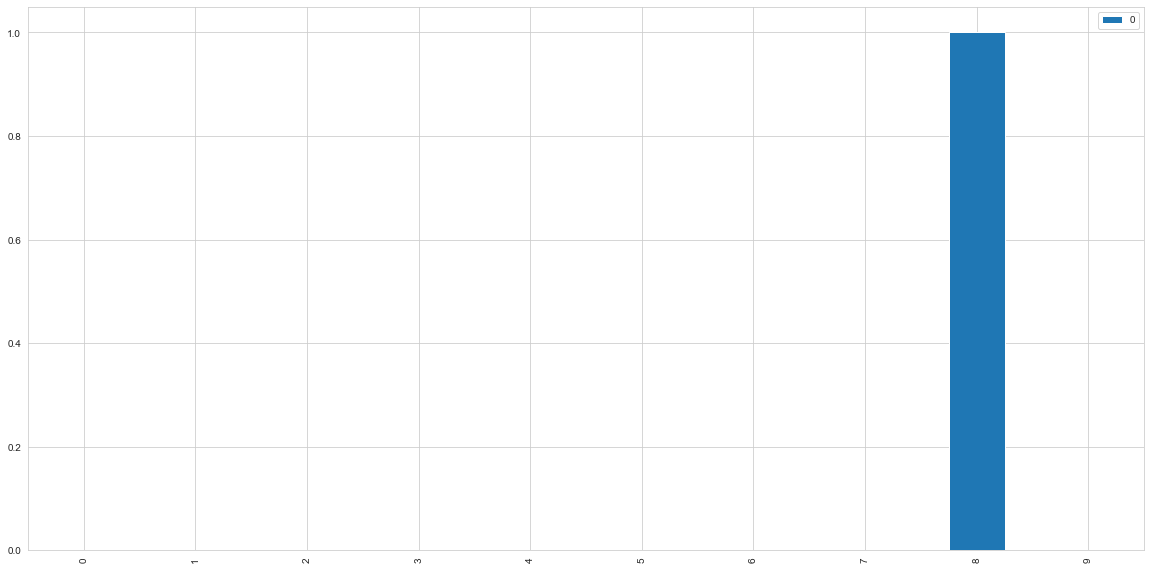

In [39]:
pd.DataFrame(action_dist[999999]).plot(kind='bar', figsize=(20,10))

In [53]:
# define Uniform Random Policy as a baseline evaluation policy
random = Random(n_actions=dataset.n_actions,)

# obtains action choice probabilities for the test set
action_dist_random = random.compute_batch_action_dist(
    n_rounds=bandit_feedback_train["n_rounds"]
)

In [54]:
action_dist_random.shape

(1000000, 10, 1)

In [55]:
action_dist_random[:10, :, 0]

array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]])

In [60]:
# calc_ground_truth_policy_value(
#     bandit_feedback=bandit_feedback_train,
#     reward_sampler=1,
#     policy=evaluation_policy
# )

  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: 'int' object is not callable

## (3) Off-Policy Evaluation (OPE)
Our next step is OPE, which aims to estimate the performance of evaluation policies using logged bandit data and OPE estimators.

Here, we use 
- `obp.ope.InverseProbabilityWeighting` (IPW)
- `obp.ope.DirectMethod` (DM)
- `obp.ope.DoublyRobust` (DR)

as OPE estimators and visualize the OPE results.

### (3-1) Obtaining a reward estimator
A reward estimator $\hat{q}(x,a)$ is needed for model dependent estimators such as DM or DR.

$\hat{q}(x,a) \approx \mathbb{E} [r \mid x,a]$

In [44]:
# estimate the expected rewards by using an ML model (Logistic Regression here)
# the estimated rewards are used by model-dependent estimators such as DM and DR
regression_model = RegressionModel(
    n_actions=dataset.n_actions,
    action_context=dataset.action_context,
    base_model=LogisticRegression(random_state=12345),
)

In [45]:
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
    n_folds=3, # use 3-fold cross-fitting
    random_state=12345,
)

In [46]:
estimated_rewards_by_reg_model.shape

(1000000, 10, 1)

In [47]:
estimated_rewards_by_reg_model[:10,:,0]

array([[0.64671129, 0.61109406, 0.58445276, 0.60920058, 0.6030542 ,
        0.27605622, 0.35882904, 0.48226318, 0.66597048, 0.60839843],
       [0.6237394 , 0.58625968, 0.56052027, 0.5831155 , 0.57628468,
        0.25548486, 0.33003692, 0.45336423, 0.64375706, 0.5855043 ],
       [0.63109207, 0.59488658, 0.56792003, 0.59296675, 0.58673825,
        0.26273163, 0.34340435, 0.46538378, 0.65074289, 0.59215358],
       [0.65509452, 0.61982562, 0.59338446, 0.61794807, 0.61185161,
        0.28349018, 0.36736091, 0.49148025, 0.67412698, 0.61715259],
       [0.66322863, 0.6270758 , 0.6016589 , 0.62444158, 0.61641365,
        0.2906637 , 0.37397029, 0.49725033, 0.68013644, 0.62505498],
       [0.62517422, 0.58774296, 0.56202689, 0.58460206, 0.57777796,
        0.25665039, 0.33139117, 0.45488095, 0.64515898, 0.58698838],
       [0.62625285, 0.58885847, 0.56316026, 0.58572008, 0.57890112,
        0.25753005, 0.33241245, 0.45602323, 0.64621264, 0.5881045 ],
       [0.63086772, 0.59337083, 0.5672420

please refer to https://arxiv.org/abs/2002.08536 about the details of the cross-fitting procedure.

### (3-2) Off-Policy Evaluation
$V(\pi_e) \approx \hat{V} (\pi_e; \mathcal{D}_b, \theta)$ using DM, IPW, and DR

In [48]:
# estimate the policy value of the evaluation policies based on their action choice probabilities
# it is possible to set multiple OPE estimators to the `ope_estimators` argument
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback_train,
    ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), DoublyRobust()]
)

In [49]:
ope.ope_estimators_

{'ipw': InverseProbabilityWeighting(lambda_=inf, use_estimated_pscore=False, estimator_name='ipw'),
 'dm': DirectMethod(estimator_name='dm'),
 'dr': DoublyRobust(lambda_=inf, use_estimated_pscore=False, estimator_name='dr')}

In [50]:
# estimate the policy value of IPWLearner with Logistic Regression
estimated_policy_value_a, estimated_interval_a = ope.summarize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=1000, # number of resampling performed in bootstrap sampling
)
estimated_policy_value_a

,estimated_policy_value,relative_estimated_policy_value
ipw,0.616012,1.141524
dm,0.646729,1.198445
dr,0.617077,1.143498


In [51]:
estimated_interval_a

,mean,95.0% CI (lower),95.0% CI (upper)
ipw,0.615838,0.611613,0.620199
dm,0.646725,0.646612,0.646833
dr,0.617065,0.614157,0.620075


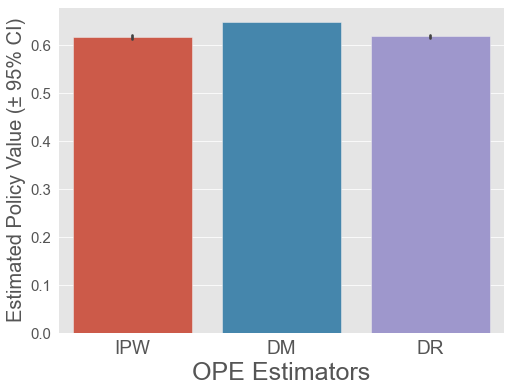

In [52]:
# visualize the estimated policy values of IPWLearner with Logistic Regression
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=1000, # number of resampling performed in bootstrap sampling
    random_state=12345,
)

In [56]:
# estimate the policy value of Uniform Random
estimated_policy_value_c, estimated_interval_c = ope.summarize_off_policy_estimates(
    action_dist=action_dist_random,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=1000, # number of resampling performed in bootstrap sampling
)
estimated_policy_value_c

,estimated_policy_value,relative_estimated_policy_value
ipw,0.499848,0.926262
dm,0.526239,0.975167
dr,0.499918,0.926392


In [57]:
estimated_interval_c

,mean,95.0% CI (lower),95.0% CI (upper)
ipw,0.499843,0.498935,0.500835
dm,0.526240,0.526120,0.526350
dr,0.499921,0.498921,0.500887


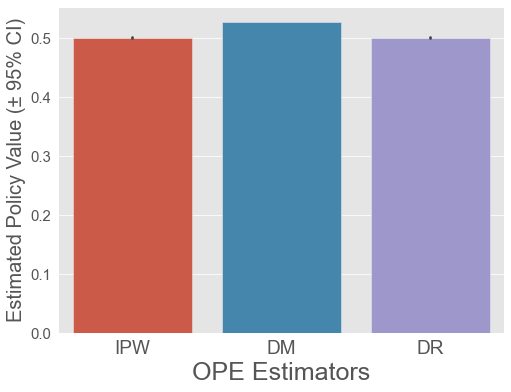

In [58]:
# visualize the estimated policy values of Uniform Random
ope.visualize_off_policy_estimates(
    action_dist=action_dist_random,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=1000, # number of resampling performed in bootstrap sampling
    random_state=12345,
)

OPE procedure estimates that IPWLearners outperform the Uniform Random policy by a large margin.

Moreover, IPWLearner with Logistic Regression seems to be the best one.

## (4) Evaluation of OPE estimators
Our final step is **the evaluation of OPE**, which evaluates and compares the estimation accuracy of OPE estimators.

### (4-1) Approximate the Ground-truth Policy Value 
With synthetic data, we can calculate the ground-truth policy value of the evaluation policies as follows.

$$V(\pi_e) \approx \frac{1}{|\mathcal{D}_{te}|} \sum_{i=1}^{|\mathcal{D}_{te}|} \mathbb{E}_{a \sim \pi_e(a|x_i)} [q(x_i, a)], \; \, where \; \, q(x,a) := \mathbb{E}_{r \sim p(r|x,a)} [r]$$

In [71]:
# we first calculate the true policy values of the three evaluation policies based on the expected rewards of the test data
policy_names = ["BerTS", "Unifrom Random"]

for name, action_dist in zip(policy_names, [action_dist, action_dist_random]):
    true_policy_value = dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback_train["expected_reward"],
        action_dist=action_dist,
    )
    print(f'policy value of {name}: {true_policy_value}')

policy value of BerTS: 0.4999101555078668
policy value of Unifrom Random: 0.4999101555078668


In fact, IPWLearner with Logistic Regression reveals the best performance among the three evaluation policies.

Using the true policy values, we evaluate the estimation accuracy of the OPE estimators.

### (4-2) Evaluation of OPE

We can then evaluate the estimation performance of OPE estimators by comparing the estimated policy values of the evaluation with its ground-truth as follows.

- $\textit{relative-ee} (\hat{V}; \mathcal{D}_b) := \left| \frac{V(\pi_e) - \hat{V} (\pi_e; \mathcal{D}_b)}{V(\pi_e)} \right|$ (relative estimation error; relative-ee)
- $\textit{SE} (\hat{V}; \mathcal{D}_b) := \left( V(\pi_e) - \hat{V} (\pi_e; \mathcal{D}_b) \right)^2$ (squared error; se)

In [65]:
# evaluate the estimation performances of OPE estimators for IPWLearner with Logistic Regression
# `summarize_estimators_comparison` returns a pandas dataframe containing estimation performances of given estimators 
relative_ee_for_berts = ope.summarize_estimators_comparison(
    ground_truth_policy_value=dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback_train["expected_reward"],
        action_dist=action_dist,
    ),
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performance of the estimators (lower means accurate)
relative_ee_for_berts

,relative-ee
ipw,0.000125
dm,0.052667
dr,0.000016


In [70]:
# evaluate the estimation performance of OPE estimators for Uniform Random
relative_ee_for_random = ope.summarize_estimators_comparison(
    ground_truth_policy_value=dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback_train["expected_reward"],
        action_dist=action_dist_random,
    ),
    action_dist=action_dist_random,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performance of the estimators (lower means accurate)
relative_ee_for_random

,relative-ee
ipw,0.000125
dm,0.052667
dr,0.000016


We can iterate the above process several times to get more reliable results.

Please see [../examples/synthetic](../synthetic) for a more sophisticated example of the evaluation of OPE with synthetic bandit data.

#### Trying `visualize_off_policy_estimates_of_multiple_policies`

- this method only works with 2 OPE methodologies

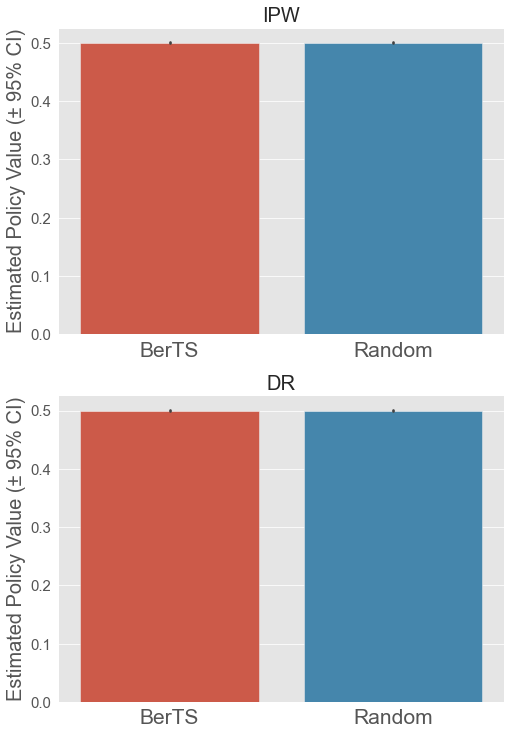

In [69]:
ope1 = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback_train,
    ope_estimators=[InverseProbabilityWeighting(), DoublyRobust()]
)

ope1.visualize_off_policy_estimates_of_multiple_policies(
    policy_name_list=["BerTS", "Random"],
    action_dist_list=[action_dist, action_dist_random],
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=1000,
    random_state=12345,
)